In [1]:
import time
import numpy as np
from IPython.display import display
import ipywidgets as widgets
from matplotlib import pyplot as plt
from qualang_tools.units import unit
u = unit(coerce_to_integer=True)
from qm.qua import *
from qualang_tools.loops import from_array
import QM

2026-01-30 16:54:56,709 - qm - INFO     - Starting session: fc0f3ed1-b5d7-415d-bb74-702b488e422f


In [57]:
t_min = 1
t_max = 8000 // 4
dt = 8 // 4
durations = np.arange(t_min, t_max, dt)
detuning = 50*u.MHz + np.arange(-5*u.MHz,5*u.MHz,50*u.kHz)
n_avg = 50
print(len(durations),'x',len(detuning),'x',n_avg)
print(f"Estimated time {sum(durations*4e-9 + 4e-6)*len(detuning)*n_avg:.1f}s")

1000 x 200 x 50
Estimated time 80.0s


In [58]:
# Pulse duration sweep (in clock cycles = 4ns) - must be larger than 4 clock cycles
###################
# The QUA program #
###################
with program() as qmprog:
    n = declare(int)  # QUA variable for the averaging loop
    t = declare(int)  # QUA variable for the qubit pulse duration
    I = declare(fixed)  # QUA variable for the measured 'I' quadrature
    Q = declare(fixed)  # QUA variable for the measured 'Q' quadrature
    fs = declare(int)
    
    Sz = declare(fixed)
    Sz_st = declare_stream()  # Stream for the state

    update_frequency('resonator',59980000)
    with for_(n, 0, n < n_avg, n + 1):  # QUA for_ loop for averaging
        with for_(*from_array(fs, detuning)):
            with for_(*from_array(t, durations)):  # QUA for_ loop for sweeping the pulse duration
                update_frequency('qubit',fs)
                # Play the qubit pulse with a variable duration (in clock cycles = 4ns)
                play("pi"*amp(0.5), "qubit", duration=t)
                # Align the two elements to measure after playing the qubit pulse.
                align("qubit", "resonator")
                # Measure the state of the resonator
                measure(
                    "readout",
                    "resonator",
                    dual_demod.full("cos", "sin", I),
                    dual_demod.full("minus_sin", "cos", Q),
                )
                # Send back qubit to ground state
                assign(Sz, Util.cond(Q>2e-4, -0.5, 0.5))
                with if_(Q>2e-4):
                    update_frequency('qubit',50000000)
                    play("pi", "qubit", duration=108*u.ns)
                save(Sz, Sz_st)

    with stream_processing():
        # Cast the data into a 1D vector, average the 1D vectors together and store the results on the OPX processor
        Sz_st.buffer(len(durations)).buffer(len(detuning)).buffer(n_avg).map(FUNCTIONS.average(0)).save("Sz")


# Send the QUA program to the OPX, which compiles and executes it
job = QM.Job(qmprog)

Button(description='Abort', style=ButtonStyle())

Output(outputs=({'output_type': 'stream', 'name': 'stdout', 'text': 'Sending job to qm-1698897807005...'}, {'o…

HTML(value='')

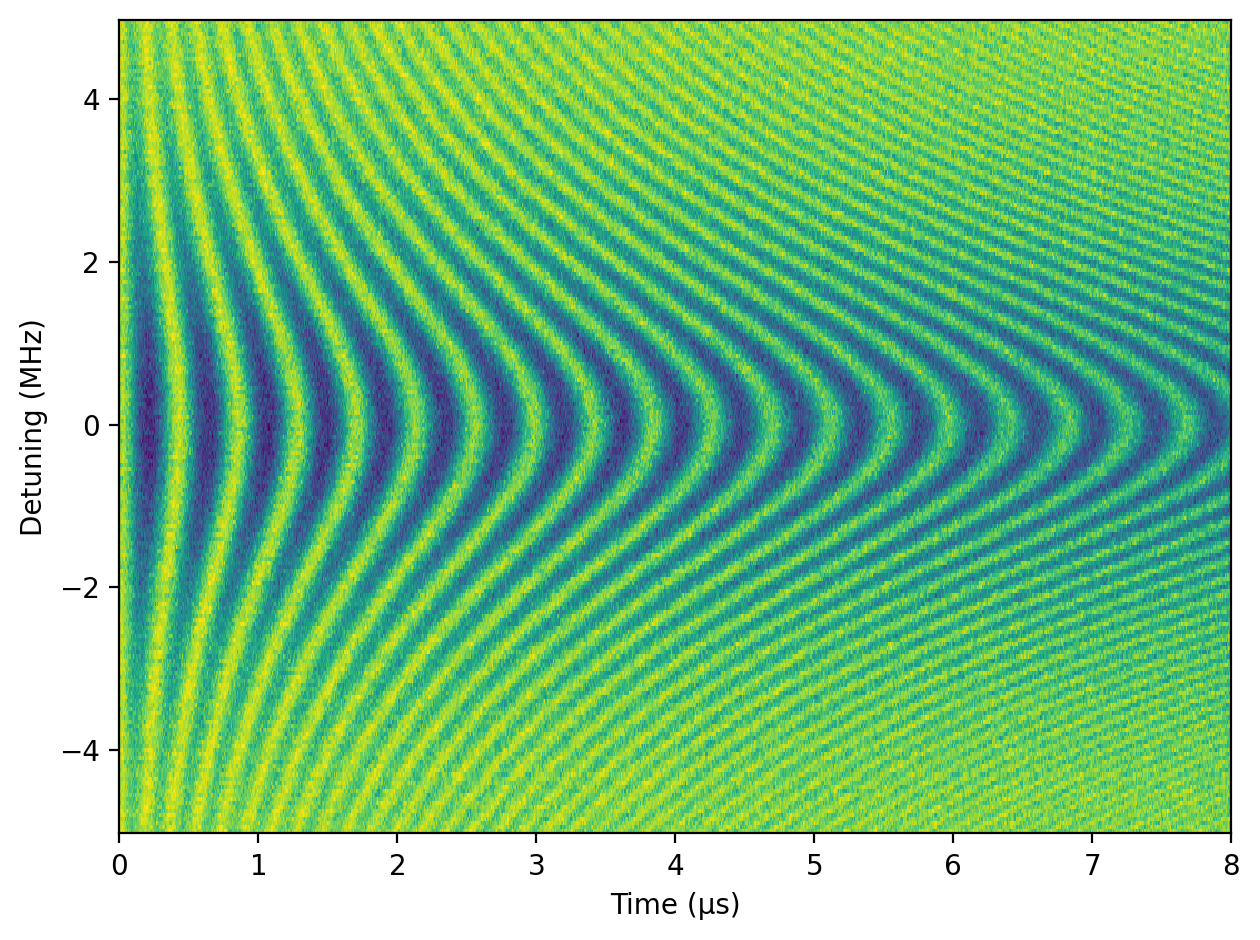

In [62]:
fig,ax=plt.subplots(dpi=200)
Sz, = job.get_results("Sz")
ax.pcolormesh(durations*4e-3,detuning/1e6-50,Sz)
plt.xlabel('Time (µs)')
plt.ylabel('Detuning (MHz)')
fig.tight_layout()
#fig.savefig('RabiChevrons.png')